In [ ]:
!pip install -q country_converter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 858.3 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import *
import os
import time
import random as rd
import country_converter as coco
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
import pickle
from nltk.tokenize import word_tokenize

nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('punkt')
sns.set_style("whitegrid")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Chọn thư mục hoạt động

%cd /content/drive/MyDrive/AI/NLP

/content/drive/MyDrive/AI/NLP


In [ ]:
# Tạo các thư mục liên quan

!rm -rf models/disneyland_reviews/
!rm -rf imgs/disneyland_reviews/
!rm -rf logs/disneyland_reviews/

!mkdir -p datasets/disneyland_reviews/
!mkdir -p models/disneyland_reviews/
!mkdir -p imgs/disneyland_reviews/
!mkdir -p logs/disneyland_reviews/

In [ ]:
# Thiết lập đường dẫn

ds_path = 'datasets/disneyland_reviews/'
model_path = 'models/disneyland_reviews/'
img_path = 'imgs/disneyland_reviews/'
log_path = 'logs/disneyland_reviews/'

In [ ]:
# Nạp API key Kaggle

!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp ../api_keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Tải tập dữ liệu từ Kaggle

import kaggle as kg

kg.api.dataset_download_files(
    'arushchillar/disneyland-reviews',
    path=ds_path,
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/arushchillar/disneyland-reviews


In [ ]:
# Liệt kê danh sách tệp

!ls {ds_path}

DisneylandReviews.csv


# Nạp dữ liệu

In [ ]:
# Nạp dữ liệu vào bộ nhớ

df = pd.read_csv(os.path.join(ds_path, 'DisneylandReviews.csv'), delimiter=',', encoding='latin1')
df.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
5,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong
7,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong


In [ ]:
# Liệt kê các thuộc tính

df.columns

Index(['Review_ID', 'Rating', 'Year_Month', 'Reviewer_Location', 'Review_Text',
       'Branch'],
      dtype='object')

In [ ]:
# Khái quát sơ lược dữ liệu

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


# Tiền xử lý dữ liệu (1)


In [ ]:
# Kiểm tra & loại bỏ giá trị N/A (nếu có)

print(df.isna().sum())
df.dropna(inplace=True)

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64


In [ ]:
# Tiền xử lý thuộc tính Year_Month

## Loại bỏ các trường dữ liệu có date bị miss
df = df[df['Year_Month'] != 'missing']

## Sửa lại định dạng datetime để convert cho chính xác
def fix_year_month(year_month):
    if not isinstance(year_month, str):
      return year_month
    year_month = year_month.split('-')
    month = year_month[1]
    year = year_month[0]
    if len(year) == 2:
        year = '20' + year
    if len(month) == 1:
        month = '0' + month
    return year + '-' + month

df['Year_Month'] = df['Year_Month'].apply(fix_year_month)
df['Year_Month'] = pd.to_datetime(df['Year_Month'], format='%Y-%m')
df.head(5)

<ipython-input-13-a05f2dfcf006>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year_Month'] = df['Year_Month'].apply(fix_year_month)
<ipython-input-13-a05f2dfcf006>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year_Month'] = pd.to_datetime(df['Year_Month'], format='%Y-%m')


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [ ]:
# Tiền xử lý thuộc tính Reviewer_Location

## Liệt kê các giá trị duy nhất
df['Reviewer_Location'].unique()

## Chuyển đổi về chuẩn ISO3 cho đồng nhất
cc = coco.CountryConverter()
df['Reviewer_Location'] = cc.pandas_convert(series=df['Reviewer_Location'], to='ISO3')
df['Reviewer_Location'].head(3)

,Reviewer_Location
0,AUS
1,PHL
2,ARE


In [ ]:
# Tiền xử lý thuộc tính Branch

## Liệt kê các giá trị duy nhất
df['Branch'].unique()

array(['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris'],
      dtype=object)

In [ ]:
# Tiền xử lý thuộc tính Rating

## Liệt kê các giá trị duy nhất
df['Rating'].unique()

array([4, 3, 5, 2, 1])

# Trực quan hóa dữ liệu

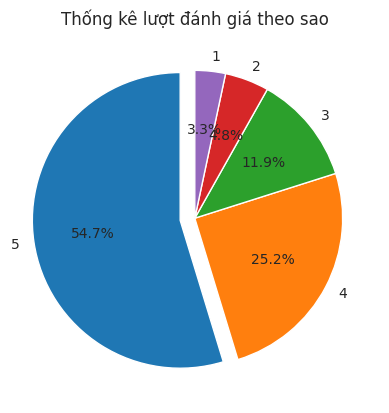

=> Disneyland có lượt đánh giá 5 sao là nhiều nhất. 
Khách hàng có nhiều trải nghiệm tuyệt vời tại Disneyland ở cả 3 chi nhánh


In [ ]:
# Thống kê lượt đánh giá theo sao

rating_counts = df['Rating'].value_counts()
labels = rating_counts.index
sizes = rating_counts.values
explode = (0.1, 0, 0, 0, 0)  # explode the 5-star slice

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
shadow=False, startangle=90)
plt.title('Thống kê lượt đánh giá theo sao')
plt.show()

max_rating = df['Rating'].value_counts().sort_index(ascending=False).index[0]
print(f'=> Disneyland có lượt đánh giá {max_rating} sao là nhiều nhất. \nKhách hàng có nhiều trải nghiệm tuyệt vời tại Disneyland ở cả 3 chi nhánh')

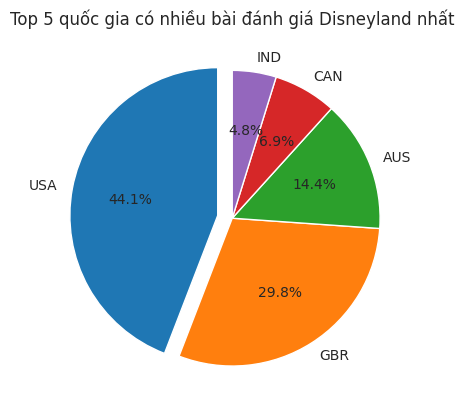

=> Nơi có nhiều lượt đánh giá về Disneyland nhất là: USA


In [ ]:
# Top 5 quốc gia có nhiều bài đánh giá Disneyland nhất

top5_locations = df['Reviewer_Location'].value_counts().iloc[:5]
explode = (0.1, 0, 0, 0, 0)
plt.pie(top5_locations.values, labels=top5_locations.index, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Top 5 quốc gia có nhiều bài đánh giá Disneyland nhất')
plt.show()

max_reviewer_location = df['Reviewer_Location'].value_counts().index[0]
print(f'=> Nơi có nhiều lượt đánh giá về Disneyland nhất là: {max_reviewer_location}')

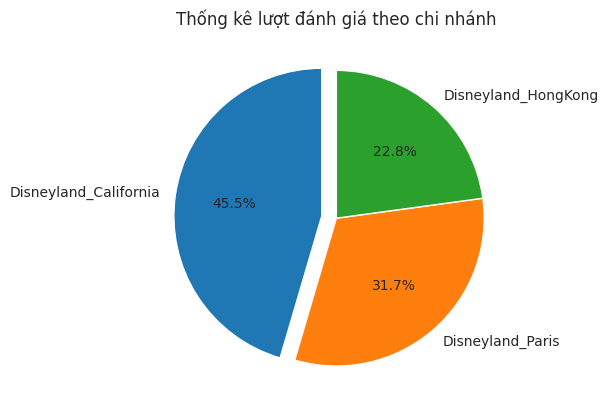

=> Chi nhánh có nhiều lượt đánh giá nhất là: Disneyland_California


In [ ]:
# Thống kê lượt đánh giá theo chi nhánh

branch_counts = df['Branch'].value_counts()
explode = (0.1, 0, 0)
plt.pie(branch_counts, labels=branch_counts.index, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Thống kê lượt đánh giá theo chi nhánh')
plt.show()

max_branch = df['Branch'].value_counts().index[0]
print(f'=> Chi nhánh có nhiều lượt đánh giá nhất là: {max_branch}')

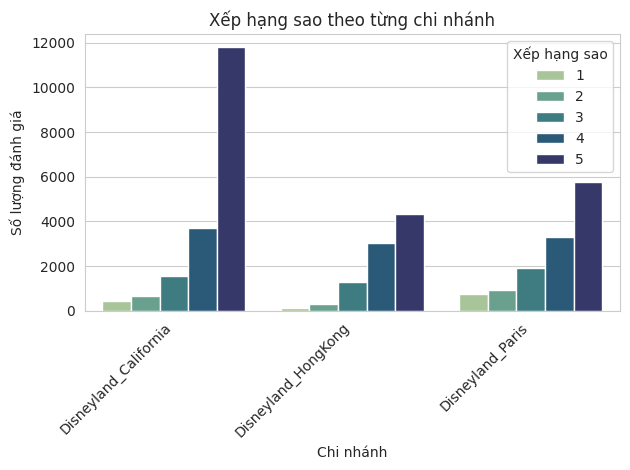

=> Chi nhánh có số lượng khách hàng đánh giá 1 sao nhiều nhất là: Disneyland_Paris
=> Chi nhánh có số lượng khách hàng đánh giá 5 sao nhiều nhất là: Disneyland_California
=> Chi nhánh có số lượng khách hàng đánh giá từ 3 sao trở xuống nhiều nhất là: Disneyland_Paris


In [ ]:
# Đánh giá xếp hạng sao theo từng chi nhánh

branch_rating_counts = df.groupby(['Branch', 'Rating'])['Review_ID'].count().reset_index(name='Count')
branch_rating_counts = branch_rating_counts.sort_values(['Branch', 'Count'], ascending=[True, False])

sns.barplot(x='Branch', y='Count', hue='Rating', data=branch_rating_counts, palette='crest')
plt.title('Xếp hạng sao theo từng chi nhánh')
plt.xlabel('Chi nhánh')
plt.ylabel('Số lượng đánh giá')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Xếp hạng sao')
plt.tight_layout()
plt.show()

max_1_rating_branch = branch_rating_counts[branch_rating_counts['Rating'] == 1].sort_values('Count', ascending=False).iloc[0]['Branch']
print(f'=> Chi nhánh có số lượng khách hàng đánh giá 1 sao nhiều nhất là: {max_1_rating_branch}')

max_5_rating_branch = branch_rating_counts[branch_rating_counts['Rating'] == 5].sort_values('Count', ascending=False).iloc[0]['Branch']
print(f'=> Chi nhánh có số lượng khách hàng đánh giá 5 sao nhiều nhất là: {max_5_rating_branch}')


low_rating_counts = branch_rating_counts[branch_rating_counts['Rating'] < 4]
max_low_rating_branch = low_rating_counts.groupby('Branch')['Count'].sum().idxmax()
print(f'=> Chi nhánh có số lượng khách hàng đánh giá từ 3 sao trở xuống nhiều nhất là: {max_low_rating_branch}')

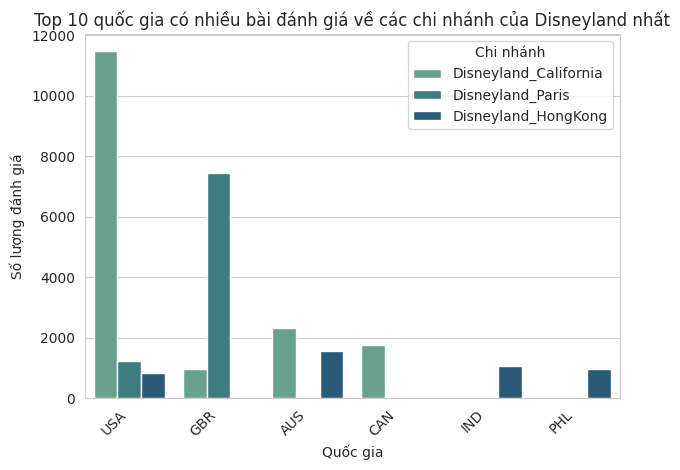

=> Disneyland thu hút nhiều lượt khách đến từ Mỹ và Anh nhất !
=> Du khách có xu hướng đến các chi nhánh gần họ nhất!
=> Disneyland phổ biến ở các quốc gia phương Tây nhiều nhất !


In [ ]:
# Top 5 quốc gia có nhiều khách để lại đánh giá sau khi trải nghiệm các chi nhánh Disneyland

location_branch_counts = df.groupby(['Reviewer_Location', 'Branch'])['Review_ID'].count().reset_index(name='Count')
location_branch_counts = location_branch_counts.sort_values('Count', ascending=False).iloc[:10]

sns.barplot(x='Reviewer_Location', y='Count', hue='Branch', data=location_branch_counts, palette='crest')
plt.title('Top 10 quốc gia có nhiều bài đánh giá về các chi nhánh của Disneyland nhất')
plt.xlabel('Quốc gia')
plt.ylabel('Số lượng đánh giá')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Chi nhánh')
plt.tight_layout()
plt.show()

print('=> Disneyland thu hút nhiều lượt khách đến từ Mỹ và Anh nhất !')
print('=> Du khách có xu hướng đến các chi nhánh gần họ nhất!')
print('=> Disneyland phổ biến ở các quốc gia phương Tây nhiều nhất !')


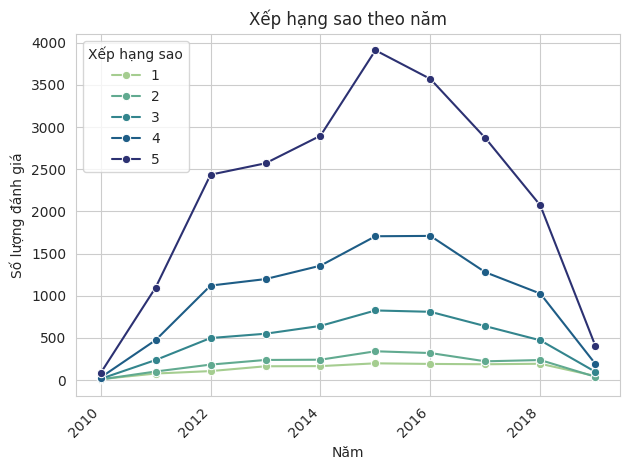

=> Năm 2015 khả năng cao có nhiều khách vui chơi nhất tại Disneyland do nhiều lượt đánh giá nhất !
=> Năm có số lượng khách hàng đánh giá 5 sao nhiều nhất là: 2015
=> Năm có số lượng khách hàng đánh giá 1 sao nhiều nhất là: 2015
=> Đánh giá của khách hàng ít dần đi qua từng năm
=> Tỉ lệ đánh giá từ 3 sao trở xuống có xu hướng giảm dần qua từng năm


In [ ]:
# Thống kê lượt xếp hạng sao theo năm theo từng năm

rating_by_year_month = df.groupby([df['Year_Month'].dt.year, 'Rating'])['Review_ID'].count().reset_index(name='Count')
rating_by_year_month = rating_by_year_month.sort_values(['Year_Month', 'Count'], ascending=[False, False])

sns.lineplot(x='Year_Month', y='Count', hue='Rating', data=rating_by_year_month, marker='o', palette='crest')
plt.title('Xếp hạng sao theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng đánh giá')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Xếp hạng sao')
plt.tight_layout()
plt.show()

max_5_rating_year = rating_by_year_month[rating_by_year_month['Rating'] == 5].sort_values('Count', ascending=False).iloc[0]['Year_Month']
max_1_rating_year = rating_by_year_month[rating_by_year_month['Rating'] == 1].sort_values('Count', ascending=False).iloc[0]['Year_Month']
max_count = rating_by_year_month.groupby('Year_Month')['Count'].sum().sort_values(ascending=False).index[0]

print(f'=> Năm {max_count} khả năng cao có nhiều khách vui chơi nhất tại Disneyland do nhiều lượt đánh giá nhất !')
print(f'=> Năm có số lượng khách hàng đánh giá 5 sao nhiều nhất là: {max_5_rating_year}')
print(f'=> Năm có số lượng khách hàng đánh giá 1 sao nhiều nhất là: {max_1_rating_year}')
print(f'=> Đánh giá của khách hàng ít dần đi qua từng năm')
print(f'=> Tỉ lệ đánh giá từ 3 sao trở xuống có xu hướng giảm dần qua từng năm')

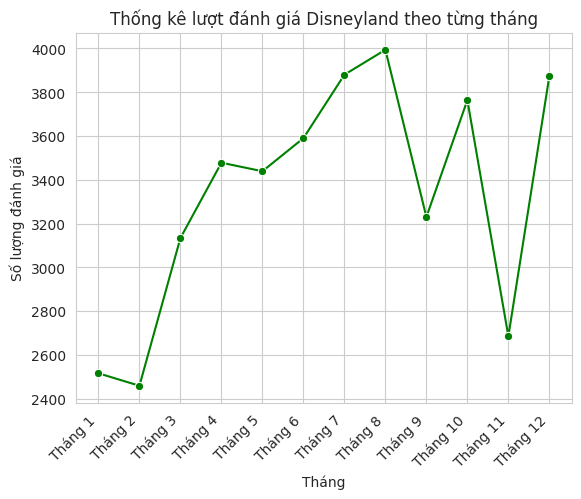

=> Khách hàng đến Disneyland nhiều vào khoảng từ tháng 7 đến tháng 10


In [ ]:
# Thống kê lượt đánh giá Disneyland theo từng tháng

value_counts_by_month = df['Year_Month'].dt.month.value_counts().sort_index()
sns.lineplot(x=value_counts_by_month.index, y=value_counts_by_month.values, marker='o', color='g')
plt.title('Thống kê lượt đánh giá Disneyland theo từng tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng đánh giá')
plt.xticks(range(1, 13), ['Tháng 1', 'Tháng 2', 'Tháng 3', 'Tháng 4', 'Tháng 5', 'Tháng 6', 'Tháng 7', 'Tháng 8', 'Tháng 9', 'Tháng 10', 'Tháng 11', 'Tháng 12'], rotation=45, ha='right')
plt.show()

print(f'=> Khách hàng đến Disneyland nhiều vào khoảng từ tháng 7 đến tháng 10')


# Tiền xử lý dữ liệu (2)

#### Thuộc tính Review_Text

In [ ]:
# In thử 5 dòng dữ liệu

df['Review_Text'].head(5)

,Review_Text
0,If you've ever been to Disneyland anywhere you...
1,Its been a while since d last time we visit HK...
2,Thanks God it wasn t too hot or too humid wh...
3,HK Disneyland is a great compact park. Unfortu...
4,"the location is not in the city, took around 1..."


In [ ]:
# Lập hàm tiền xử lý chuỗi

def text_preprocessing(text):
  # Chuyển đổi chữ thường
  text = text.lower()
  # Loại bỏ HTML Tags
  text = strip_tags(text)
  # Loại bỏ các kí tự "lạ" (vd: emoji, ...)
  text = strip_non_alphanum(text)
  # Loại bỏ các số
  text = strip_numeric(text)
  # Loại bỏ dấu câu
  text = strip_punctuation(text)
  # Loại bỏ các từ có độ dài dưới 3 kí tự
  text = strip_short(text, 3)
  # Loại bỏ các từ dừng
  text = remove_stopwords(text)
  # Chuẩn hóa ngữ nghĩa theo thừ điển WordNet
  text = WordNetLemmatizer().lemmatize(text)
  # Loại bỏ các khoảng trắng thừa
  text = strip_multiple_whitespaces(text)
  return text

print(text_preprocessing(df['Review_Text'][0]))

disneyland disneyland hong kong similar layout walk main street familiar feel rides small world absolutely fabulous worth day visited fairly hot relatively busy queues moved fairly


In [ ]:
# Bắt đầu tiền xử lý chuỗi

df['Review_Text'] = df['Review_Text'].apply(text_preprocessing)
df['Review_Text'].head(5)

,Review_Text
0,disneyland disneyland hong kong similar layout...
1,time visit disneyland time stay tomorrowland a...
2,thanks god wasn hot humid visiting park big is...
3,disneyland great compact park unfortunately bi...
4,location city took hour kowlon kids like disne...


# Sentiment Analytics

#### VADER

In [ ]:
# Phân tích cảm xúc từ đoạn văn đánh giá bằng VADER

sia = SentimentIntensityAnalyzer()
df['vader_review_text_sentiments'] = df['Review_Text'].apply(lambda review: sia.polarity_scores(review))
df['compound']  = df['vader_review_text_sentiments'].apply(lambda x: x['compound'])

def get_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['compound'].apply(get_sentiment)

df = df.drop(columns=['compound'])

df.head(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,vader_review_text_sentiments,vader_sentiment
0,670772142,4,2019-04-01,AUS,disneyland disneyland hong kong similar layout...,Disneyland_HongKong,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...",positive
1,670682799,4,2019-05-01,PHL,time visit disneyland time stay tomorrowland a...,Disneyland_HongKong,"{'neg': 0.074, 'neu': 0.584, 'pos': 0.341, 'co...",positive
2,670623270,4,2019-04-01,ARE,thanks god wasn hot humid visiting park big is...,Disneyland_HongKong,"{'neg': 0.064, 'neu': 0.514, 'pos': 0.422, 'co...",positive
3,670607911,4,2019-04-01,AUS,disneyland great compact park unfortunately bi...,Disneyland_HongKong,"{'neg': 0.118, 'neu': 0.609, 'pos': 0.273, 'co...",positive
4,670607296,4,2019-04-01,GBR,location city took hour kowlon kids like disne...,Disneyland_HongKong,"{'neg': 0.0, 'neu': 0.719, 'pos': 0.281, 'comp...",positive
5,670591897,3,2019-04-01,SGP,disney world disneyland anaheim tokyo disneyla...,Disneyland_HongKong,"{'neg': 0.164, 'neu': 0.628, 'pos': 0.209, 'co...",positive
6,670585330,5,2019-04-01,IND,great place day won know obviously went daught...,Disneyland_HongKong,"{'neg': 0.147, 'neu': 0.388, 'pos': 0.465, 'co...",positive
7,670574142,3,2019-03-01,MYS,think intro disney magic little ones attractio...,Disneyland_HongKong,"{'neg': 0.054, 'neu': 0.804, 'pos': 0.142, 'co...",positive
8,670571027,2,2019-04-01,AUS,feel let place disneyland train fantastic past...,Disneyland_HongKong,"{'neg': 0.163, 'neu': 0.614, 'pos': 0.223, 'co...",positive
9,670570869,5,2019-03-01,IND,talking disneyland disneyland childhood dreams...,Disneyland_HongKong,"{'neg': 0.076, 'neu': 0.62, 'pos': 0.304, 'com...",positive


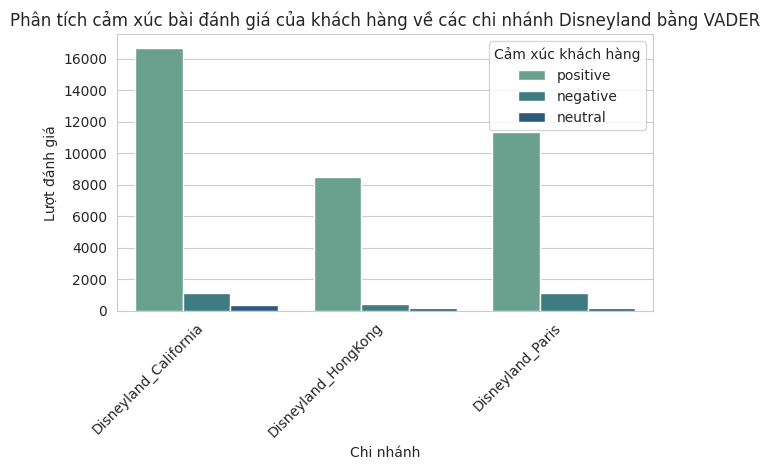

=> Chi nhánh Paris nhận được nhiều đánh giá negative nhất !


In [ ]:
# Phân tích cảm xúc bài đánh giá của khách hàng về các chi nhánh bằng VADER

branch_sentiment_counts = df.groupby(['Branch', 'vader_sentiment'])['Review_ID'].count().reset_index(name='Count')
branch_sentiment_counts = branch_sentiment_counts.sort_values(['Branch', 'Count'], ascending=[True, False])

sns.barplot(x='Branch', y='Count', hue='vader_sentiment', data=branch_sentiment_counts, palette='crest')
plt.title('Phân tích cảm xúc bài đánh giá của khách hàng về các chi nhánh Disneyland bằng VADER')
plt.xlabel('Chi nhánh')
plt.ylabel('Lượt đánh giá')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cảm xúc khách hàng')
plt.tight_layout()
plt.show()

print('=> Chi nhánh Paris nhận được nhiều đánh giá negative nhất !')

#### TextBlob

In [ ]:
# Phân tích cảm xúc đánh giá bằng TextBlob

df['textblob_polarity'] = df['Review_Text'].apply(lambda review: TextBlob(review).sentiment.polarity)
df['textblob_subjectivity'] = df['Review_Text'].apply(lambda review: TextBlob(review).sentiment.subjectivity)

def get_textblob_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['textblob_sentiment'] = df['textblob_polarity'].apply(get_textblob_sentiment)

df['textblob_sentiment'].head(10)

,textblob_sentiment
0,positive
1,positive
2,positive
3,positive
4,positive
5,negative
6,positive
7,positive
8,negative
9,positive


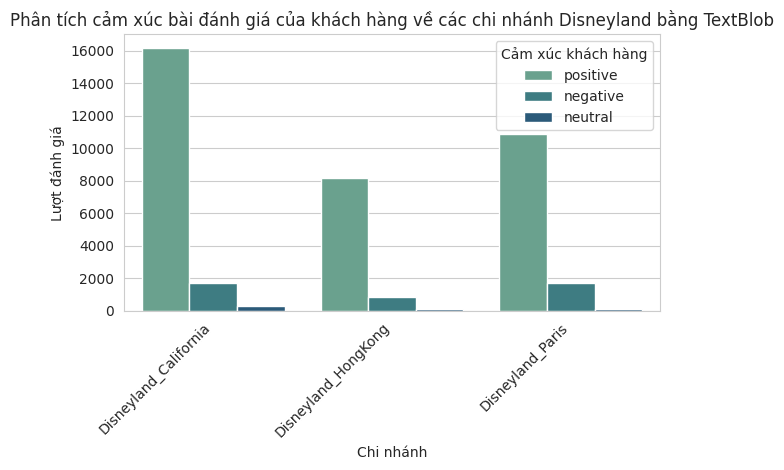

In [ ]:
# Phân tích cảm xúc bài đánh giá của khách hàng về các chi nhánh bằng TextBlob

branch_sentiment_counts = df.groupby(['Branch', 'textblob_sentiment'])['Review_ID'].count().reset_index(name='Count')
branch_sentiment_counts = branch_sentiment_counts.sort_values(['Branch', 'Count'], ascending=[True, False])

sns.barplot(x='Branch', y='Count', hue='textblob_sentiment', data=branch_sentiment_counts, palette='crest')
plt.title('Phân tích cảm xúc bài đánh giá của khách hàng về các chi nhánh Disneyland bằng TextBlob')
plt.xlabel('Chi nhánh')
plt.ylabel('Lượt đánh giá')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cảm xúc khách hàng')
plt.tight_layout()
plt.show()

# Tiền xử lý dữ liệu (3)

In [ ]:
# Mapping sentimens sang số nguyên

sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

df['vader_sentiment'] = df['vader_sentiment'].map(sentiment_mapping)
df['textblob_sentiment'] = df['textblob_sentiment'].map(sentiment_mapping)

In [ ]:
# Khởi tạo nhãn

classes = ['negative', 'neutral', 'positive']
classes

['negative', 'neutral', 'positive']

vader_sentiment
2    36576
0     2757
1      710
Name: count, dtype: int64
textblob_sentiment
2    35277
0     4237
1      529
Name: count, dtype: int64


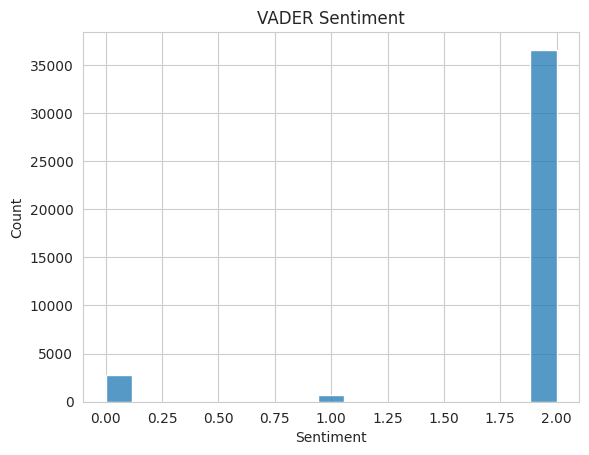

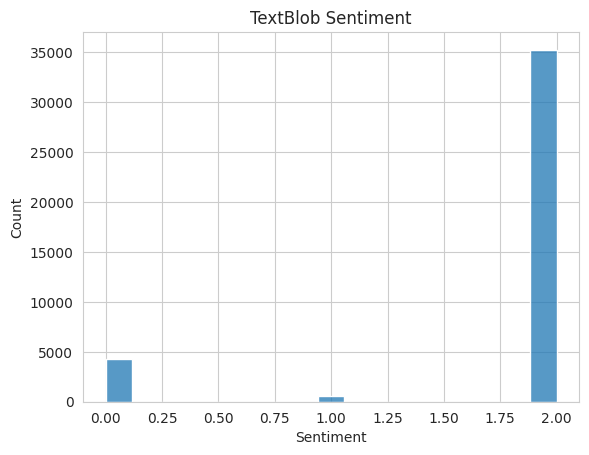

=> Lớp 0 và 1 bị mất cân bằng nghiêm trọng !


In [ ]:
# Kiểm tra cân bằng lớp

print(df['vader_sentiment'].value_counts())
print(df['textblob_sentiment'].value_counts())

sns.histplot(df['vader_sentiment'])
plt.title('VADER Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

sns.histplot(df['textblob_sentiment'])
plt.title('TextBlob Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

print('=> Lớp 0 và 1 bị mất cân bằng nghiêm trọng !')

In [ ]:
# Vectơ hóa chuỗi bằng TF-IDF

vectorizer = TfidfVectorizer(max_features=1000)
text_vectorized = vectorizer.fit_transform(df['Review_Text']).toarray()
text_vectorized

array([[0.        , 0.        , 0.20918323, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07994063, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Xây dựng & đào tạo mô hình phân loại

==== VADER_SENTIMENT ====
BernoulliNB() 0.6791529317750474
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       696
           1       0.04      0.76      0.08       163
           2       0.98      0.70      0.81      9152

    accuracy                           0.68     10011
   macro avg       0.48      0.62      0.44     10011
weighted avg       0.92      0.68      0.77     10011

Time for fit: 0.77 sec.


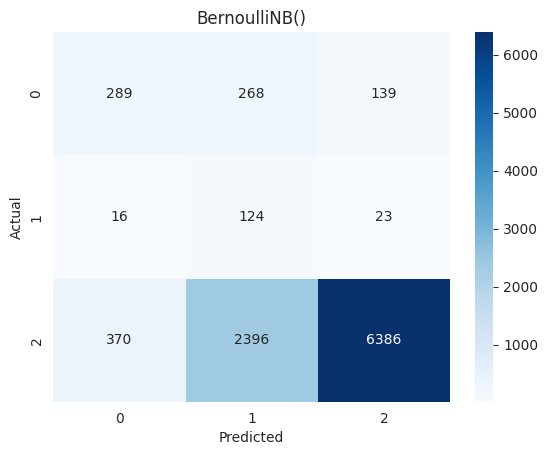

GaussianNB() 0.5649785236240136
              precision    recall  f1-score   support

           0       0.20      0.36      0.25       696
           1       0.03      0.67      0.06       163
           2       0.98      0.58      0.73      9152

    accuracy                           0.56     10011
   macro avg       0.40      0.53      0.35     10011
weighted avg       0.91      0.56      0.68     10011

Time for fit: 1.17 sec.


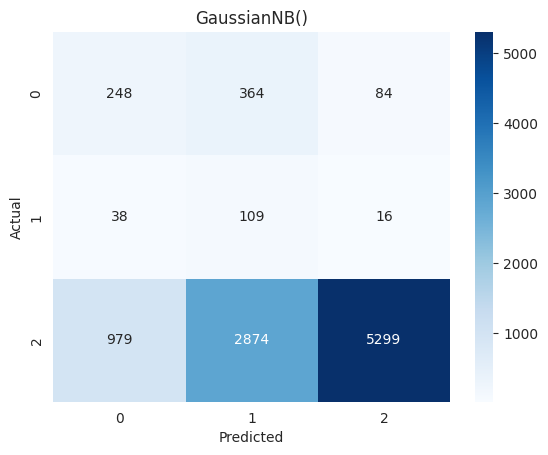

DecisionTreeClassifier() 0.8858255918489661
              precision    recall  f1-score   support

           0       0.33      0.34      0.34       696
           1       0.22      0.26      0.24       163
           2       0.94      0.94      0.94      9152

    accuracy                           0.89     10011
   macro avg       0.50      0.51      0.51     10011
weighted avg       0.89      0.89      0.89     10011

Time for fit: 29.58 sec.


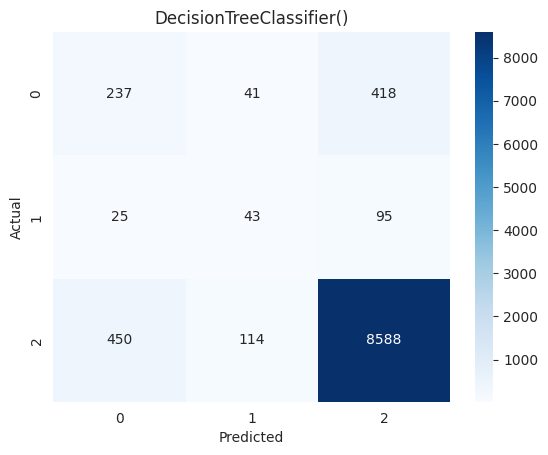

RandomForestClassifier() 0.9185895514933573
              precision    recall  f1-score   support

           0       0.79      0.08      0.14       696
           1       1.00      0.01      0.02       163
           2       0.92      1.00      0.96      9152

    accuracy                           0.92     10011
   macro avg       0.90      0.36      0.37     10011
weighted avg       0.91      0.92      0.89     10011

Time for fit: 59.72 sec.


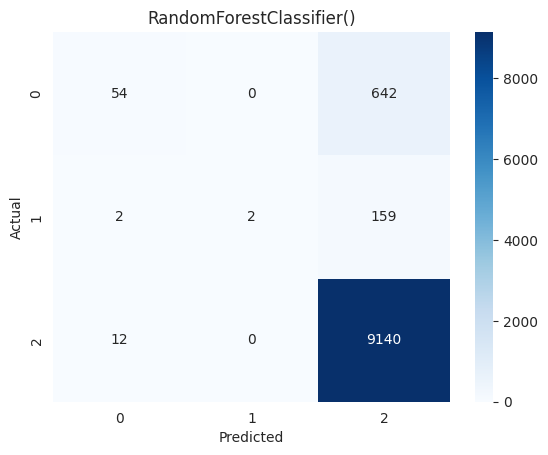

LogisticRegression() 0.9358705424033563
              precision    recall  f1-score   support

           0       0.79      0.40      0.53       696
           1       1.00      0.01      0.02       163
           2       0.94      0.99      0.97      9152

    accuracy                           0.94     10011
   macro avg       0.91      0.47      0.51     10011
weighted avg       0.93      0.94      0.92     10011

Time for fit: 22.35 sec.


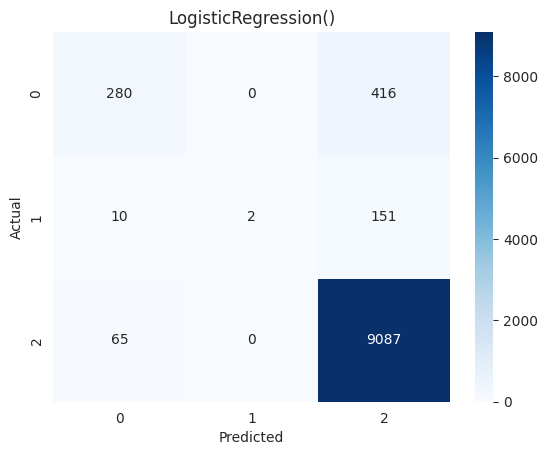

=> Best model: LogisticRegression() 0.9358705424033563
==== TEXTBLOB_SENTIMENT ====
BernoulliNB() 0.7102187593646988
              precision    recall  f1-score   support

           0       0.54      0.51      0.53      1067
           1       0.06      0.88      0.11       147
           2       0.96      0.73      0.83      8797

    accuracy                           0.71     10011
   macro avg       0.52      0.71      0.49     10011
weighted avg       0.90      0.71      0.79     10011

Time for fit: 1.08 sec.


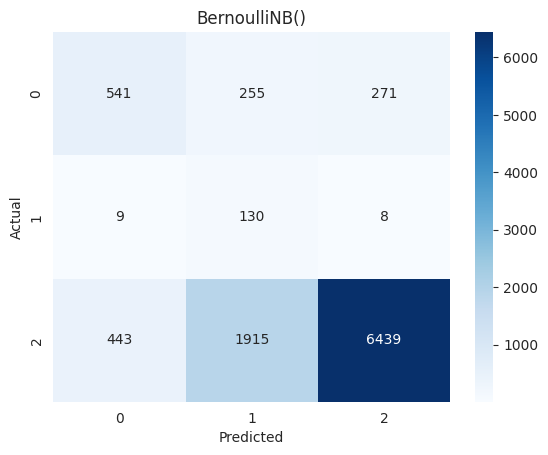

GaussianNB() 0.6986315053441214
              precision    recall  f1-score   support

           0       0.29      0.66      0.41      1067
           1       0.07      0.54      0.12       147
           2       0.96      0.71      0.81      8797

    accuracy                           0.70     10011
   macro avg       0.44      0.64      0.45     10011
weighted avg       0.88      0.70      0.76     10011

Time for fit: 0.98 sec.


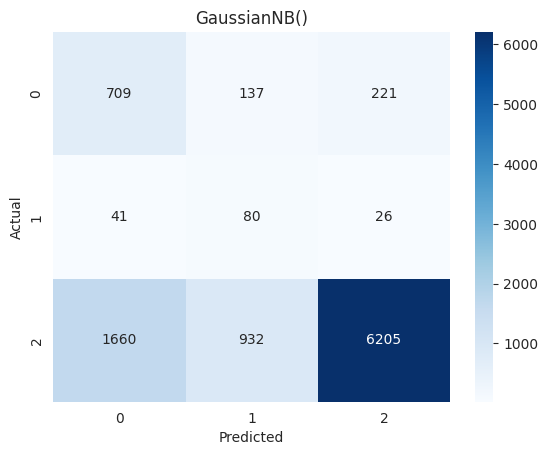

DecisionTreeClassifier() 0.8719408650484467
              precision    recall  f1-score   support

           0       0.46      0.44      0.45      1067
           1       0.37      0.33      0.35       147
           2       0.93      0.93      0.93      8797

    accuracy                           0.87     10011
   macro avg       0.59      0.57      0.58     10011
weighted avg       0.87      0.87      0.87     10011

Time for fit: 26.94 sec.


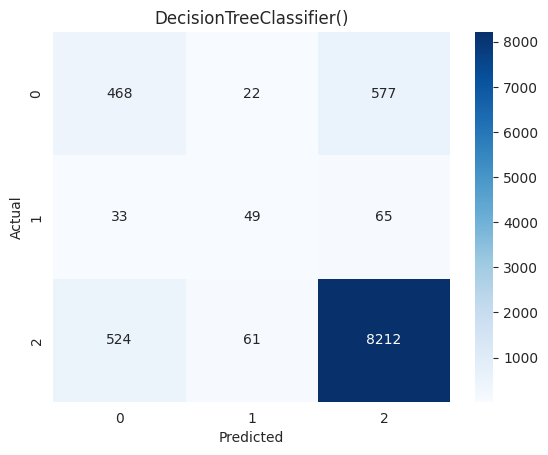

RandomForestClassifier() 0.8965138347817401
              precision    recall  f1-score   support

           0       0.87      0.19      0.31      1067
           1       0.62      0.03      0.06       147
           2       0.90      1.00      0.94      8797

    accuracy                           0.90     10011
   macro avg       0.80      0.41      0.44     10011
weighted avg       0.89      0.90      0.86     10011

Time for fit: 65.51 sec.


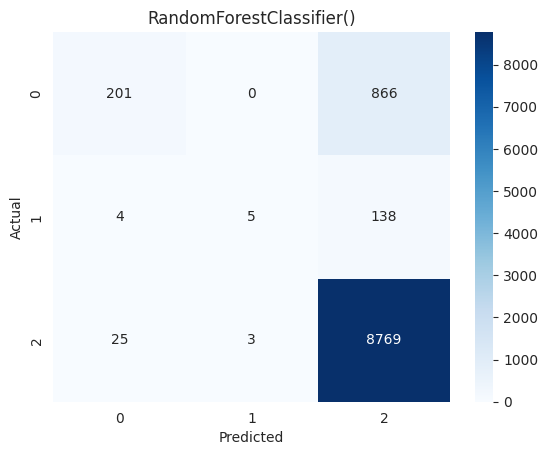

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() 0.9292777944261312
              precision    recall  f1-score   support

           0       0.85      0.56      0.67      1067
           1       0.00      0.00      0.00       147
           2       0.94      0.99      0.96      8797

    accuracy                           0.93     10011
   macro avg       0.60      0.52      0.54     10011
weighted avg       0.91      0.93      0.92     10011

Time for fit: 24.98 sec.


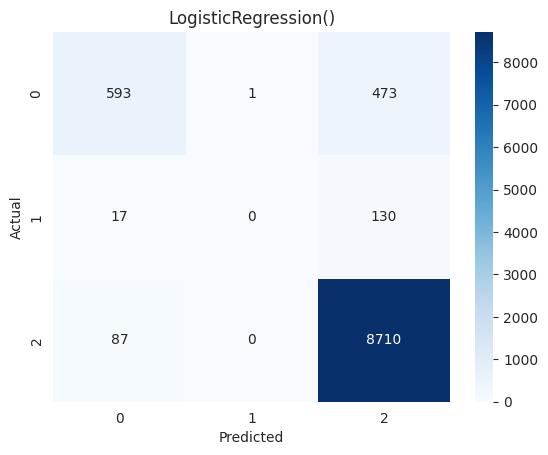

=> Best model: LogisticRegression() 0.9292777944261312
=== VADER_SENTIMENT ===
Độ chính xác trung bình cho cả 4 thuật toán: 0.7968834282289482
Mô hình tốt nhất: LogisticRegression()
=== TEXTBLOB_SENTIMENT ===
Độ chính xác trung bình cho cả 4 thuật toán: 0.8213165517930276
Mô hình tốt nhất: LogisticRegression()


In [ ]:
sentiments = ['vader_sentiment', 'textblob_sentiment']
models = [BernoulliNB(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression()]
test_size = .25
mean_accuracy_per_sentiments = {}
accuracy_models = {}
best_models = {}
f1_score_models = {
    'vader_sentiment': {},
    'textblob_sentiment': {}
}

for sentiment in sentiments:
  accuracy_models.clear()

  print('====', sentiment.upper(), '====')

  # Hợp nhất tập x, y
  x = text_vectorized
  y = df[sentiment]

  # Chia tập train, test tỉ lệ 75:25
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

  # Xây dựng & đào tạo mô hình
  for model in models:

    # Bắt đầu đếm thời gian để fit mô hình
    start_time = time.time()

    # Đào tạo mô hình & dự đoán tập Test
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Tính độ chính xác giữa lớp dự đoán và lớp thực của tập Test
    acc = accuracy_score(y_test, y_pred)
    print(model, acc)
    accuracy_models[model] = acc

    # Tính & lưu f1 score mô hình phục vụ trực quan hóa biểu đồ
    f1s = f1_score(y_test, y_pred, average='macro')
    f1_score_models[sentiment].update(
        {
            model: f1s
        }
    )

    # Đánh giá f1_score các lớp & in thời gian fit mô hình
    print(classification_report(y_test, y_pred))
    print('Time for fit:', round(time.time() - start_time, 2), 'sec.')

    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(model)
    plt.show()

  # In & lưu mô hình tốt nhất của một sentiment
  best_model = max(accuracy_models, key=accuracy_models.get)
  print('=> Best model:', best_model, accuracy_models[best_model])
  best_models[sentiment] = best_model

  # Tính độ chính xác trung bình của một sentiment
  mean_accuracy_per_sentiments[sentiment] = np.mean(list(accuracy_models.values()))

for item in mean_accuracy_per_sentiments.items():
  print(f'=== {item[0].upper()} ===')
  print(f'Độ chính xác trung bình cho cả 4 thuật toán: {item[1]}')
  print(f'Mô hình tốt nhất: {best_models[item[0]]}')


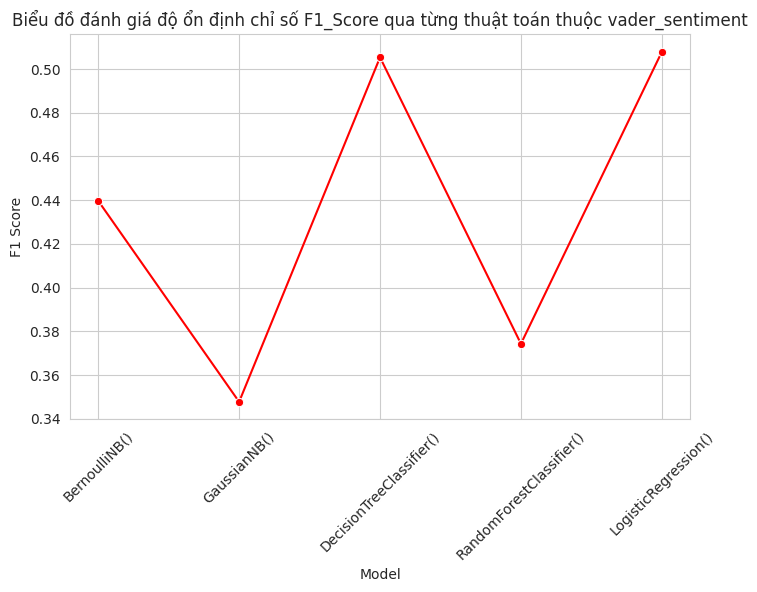

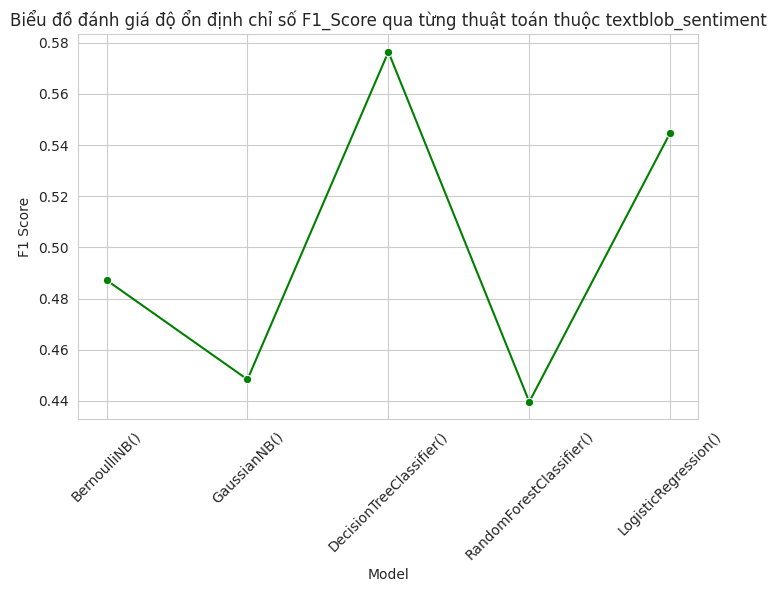

=> Hầu hết các thuật toán ở cả 2 sentiment đều cho chỉ số F1 Score thấp !
 Do ảnh hưởng của sự mất cân bằng lớp !
=> Phương pháp hồi quy Logistic & cây quyết định có xử lý khá tốt trên tập dữ liệu mất cân bằng !


In [ ]:
# Trực quan hóa chỉ số F1_score

colors = ['r', 'g']
for i, sentiment in enumerate(sentiments):
  my_sentiment = f1_score_models[sentiment]

  # Convert sang pandas
  data = {
      'Model': list(my_sentiment.keys()),
      'F1 Score': list(my_sentiment.values()),
      'Index': range(len(my_sentiment))
  }
  data = pd.DataFrame(data)

  # Sắp xếp giảm dần theo cột 'F1 Score'
  data = data.sort_values(by='F1 Score', ascending=False)

  # Vẽ biểu đồ lineplot đánh giá độ ổn định chỉ số F1_Score của từng thuật toán
  plt.figure(figsize=(8, 5))
  sns.lineplot(x='Index', y='F1 Score', data=data, marker='o', color=colors[i])
  plt.title(f'Biểu đồ đánh giá độ ổn định chỉ số F1_Score qua từng thuật toán thuộc {sentiment}')
  plt.xlabel('Model')
  plt.ylabel('F1 Score')
  plt.xticks(ticks=data['Index'], labels=data['Model'], rotation=45)
  plt.show()

print('=> Hầu hết các thuật toán ở cả 2 sentiment đều cho chỉ số F1 Score thấp !\n Do ảnh hưởng của sự mất cân bằng lớp !')
print('=> Phương pháp hồi quy Logistic & cây quyết định có xử lý khá tốt trên tập dữ liệu mất cân bằng !')


In [ ]:
# Lưu mô hình tốt nhất

for item in best_models.items():
  with open(os.path.join(model_path, f'{item[0]}_model.pkl'), 'wb') as f:
    pickle.dump(item[1], f)

# Dự đoán mẫu dữ liệu mới

In [ ]:
!ls {model_path}

textblob_sentiment_model.pkl  vader_sentiment_model.pkl


In [ ]:
# Nạp mô hình đã Train

with open(os.path.join(model_path, 'vader_sentiment_model.pkl'), 'rb') as f:
  vader_model = pickle.load(f)

with open(os.path.join(model_path, 'textblob_sentiment_model.pkl'), 'rb') as f:
  textblob_model = pickle.load(f)

In [ ]:
while True:
  input_text = input('Nhập phản hồi khách hàng: ')

  if input_text == 'exit':
    break

  # Tiền xử lý chuỗi
  input_text_preprocessed = text_preprocessing(input_text)

  # Vectơ hóa chuỗi
  input_vectorized = vectorizer.transform([input_text_preprocessed])

  # Tính xác suất từng lớp
  vader_proba = vader_model.predict_proba(input_vectorized)[0]
  textblob_proba = textblob_model.predict_proba(input_vectorized)[0]

  # In xác suất từng lớp
  print('=== VADER proba ===')
  for i, class_name in enumerate(classes):
    print(f'{class_name}: {vader_proba[i]:.2f}')

  print('=== TextBlob proba ===')
  for i, class_name in enumerate(classes):
    print(f'{class_name}: {textblob_proba[i]:.2f}')

  # Dự đoán các kết quả cuối cùng
  vader_prediction = vader_model.predict(input_vectorized)
  textblob_prediction = textblob_model.predict(input_vectorized)

  # In các kết quả dự đoán cuối cùng
  print('=> VADER:', classes[vader_prediction[0]])
  print('=> TextBlob:', classes[textblob_prediction[0]])

  print('\n')

Nhập phản hồi khách hàng: I am having a bad day
=== VADER proba ===
negative: 0.99
neutral: 0.00
positive: 0.01
=== TextBlob proba ===
negative: 0.99
neutral: 0.00
positive: 0.01
=> VADER: negative
=> TextBlob: negative


Nhập phản hồi khách hàng: I love Disneyland so much !()
=== VADER proba ===
negative: 0.00
neutral: 0.00
positive: 0.99
=== TextBlob proba ===
negative: 0.00
neutral: 0.00
positive: 0.99
=> VADER: positive
=> TextBlob: positive


Nhập phản hồi khách hàng: i having really a happy day in _ Disneyland 
=== VADER proba ===
negative: 0.00
neutral: 0.00
positive: 1.00
=== TextBlob proba ===
negative: 0.00
neutral: 0.00
positive: 1.00
=> VADER: positive
=> TextBlob: positive


Nhập phản hồi khách hàng: exit
